In [9]:
import gym
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt


In [66]:
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)

observation = env.reset()
print("Initial observations:", observation)
print(type(observation))

observation, reward, done, info, extra_info = env.step(0)

print("New observations after choosing action 0:", observation)
print(type(observation))
print("Reward for this step:", reward)
print("Is this round done?", done)

observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info, extra_info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Initial observations: (array([ 0.04995582, -0.02954555,  0.04812894, -0.02210804], dtype=float32), {})
<class 'tuple'>
New observations after choosing action 0: [ 0.0493649  -0.2253235   0.04768678  0.28536326]
<class 'numpy.ndarray'>
Reward for this step: 1.0
Is this round done? False
Cumulative reward for this round: 9.0


### Task 1:  Development of an RL Agent

In [114]:
class Monte_Carlo():
    def __init__(self, env, y = 0.99, e = 0.1, e_rate = 0.999) -> None:
        self.env = env
        self.q_table = defaultdict(int)
        self.returns = defaultdict(int)
        self.visits = defaultdict(int)
        self.discount_factor = y
        self.epsilon = e # Exploration rate
        self.epsilon_decay = e_rate # To encourage exploitation over time
    
    def discretise_state(self, state: np.ndarray) -> tuple:
        """Discretizes continuous state into a tuple."""
        state[0] = np.round(state[0], 1)
        state[1] = np.round(state[1], 0)   
        state[2] = np.round(state[2], 2)
        state[3] = np.round(state[3], 0)
        return tuple(state)
    
    def decay_epsilon(self) -> None:
        """Decays epsilon after each episode."""
        self.epsilon = max(self.epsilon * self.epsilon_decay, 0.01) # Minimum threshold at 1%

    def policy(self, state) -> int:
        """Selects an action using an ε-greedy policy."""
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.env.action_space.n))
        else:
            return max(range(self.env.action_space.n), key=lambda a: self.q_table.get((state, a), 0))

    def generate_episode(self) -> list:
        """Generates one round of play."""
        episode = []
        state, _ = self.env.reset()
        state = self.discretise_state(state)
        done = False

        while not done:
            action = self.policy(state)
            next_state, reward, done, _, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = self.discretise_state(next_state)

        return episode
    
    def generate_return(self, episode) -> None:
        """Computes returns using first-visit MC method."""
        G = 0
        state_action_visited = set()

        # Iterate backwards according to G(t) = r(t) + y * G(t+1)
        for i in reversed(range(len(episode))):
            state, action, reward = episode[i]
            G = reward + self.discount_factor * G

            # First-visit MC is actually its last occurrence in the episode
            if (state, action) not in state_action_visited:
                state_action_visited.add((state, action))
                self.returns[(state, action)] += G
                self.visits[(state, action)] += 1
                self.q_table[(state, action)] = self.returns[(state, action)] / self.visits[(state, action)]

    def train(self, num_episodes) -> list:
        """Runs for multiple episodes."""
        reward_list = []
        for _ in range(num_episodes):
            episode = self.generate_episode()
            self.generate_return(episode)
            reward_list.append(self.reward_per_episode(episode))
            self.decay_epsilon()
        
        return reward_list

    def reward_per_episode(self, episode) -> int:
        return sum([reward for _, _, reward in episode])


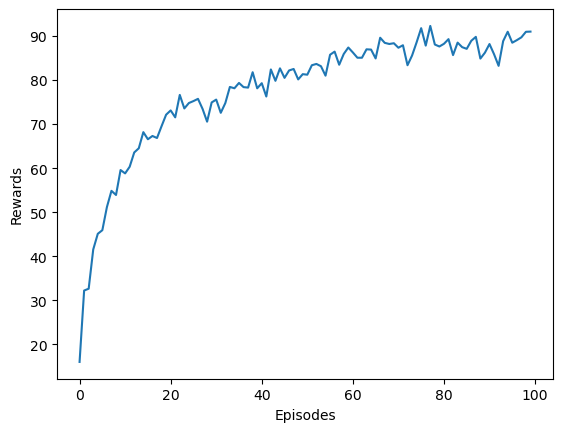

In [115]:
Monte_Carlo_Agent = Monte_Carlo(env)
fig, ax = plt.subplots() 
reward = []
for i in range(100):
    reward_list = Monte_Carlo_Agent.train(100)
    reward.append(np.mean(reward_list))

plt.plot(reward)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes')
plt.show()